# ML Pipeline de Operaciones en Flood para Predecir Destruction Level con RandomForestClassifier

## Objetivos

### Predecir Destruction Level (y numérica) a partir de X con features numéricas.

Agrupar múltiples operaciones en un mismo objeto:

* Borrar columnas, imputar valores faltantes
* Preprocessing: Umbrales a partir de percentiles y función estadística para determinar niveles de bajo a muy alto a imputar en columna categórica Flood Type.
* OneHotEncoder para pasar de columna categórica Flood Type a numérica Destruction Level.
* Pipeline:
    + Imputar most_frequent a nulos con SimpleImputer
    + Escalar características numéricas
    + RandomForestClassifier
* Modelado para predecir Destruction Level

## Importar librerías

In [295]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Split X train y test
from sklearn.model_selection import train_test_split

# Imputador para columnas de Totales de Impacto


# Modelos para validación cruzada con cross_val_score y cross_validate
from sklearn.ensemble import RandomForestClassifier # Elegido
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Modelos para validar por regresión
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor

# Validación de modelos:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

# Calificación de modelos
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import make_scorer
from sklearn.metrics import SCORERS

# Para imputación categórica a numérica y predicción de columna numérica Destruction Level en Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder

from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor

# Convertir columnas categóricas (Disaster Subtype, Origin, Associated Disaster) a numéricas para predecir Destruction Level Dis o Mag Value
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans

# Pipeline
from sklearn.pipeline import Pipeline
import joblib # guardar pipeline

In [296]:
# Display all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Cargar datos

In [297]:
df = pd.read_csv('../../../Data/03Limpio/03desastreslimpio.csv')
df.head(10)

,Dis No,Year,Seq,Disaster Subgroup,Disaster Type,Disaster Subtype,Country,ISO,Region,Continent,Location,Origin,Associated Dis,Dis Mag Value,Dis Mag Scale,Latitude,Longitude,Start Year,Start Month,Start Day,End Year,End Month,End Day,Total Deaths,Total Affected,Total Damages Adj
0,1900-9002-CPV,1900,9002,Climatological,Drought,Drought,Cabo Verde,CPV,Western Africa,Africa,Countrywide,NaN,Famine,0,Km2,NaN,NaN,1900,0,0,1900,0,0,11000,0,0
1,1900-9001-IND,1900,9001,Climatological,Drought,Drought,India,IND,Southern Asia,Asia,Bengal,NaN,NaN,0,Km2,NaN,NaN,1900,0,0,1900,0,0,1250000,0,0
2,1902-0012-GTM,1902,12,Geophysical,Earthquake,Ground movement,Guatemala,GTM,Central America,Americas,"Quezaltenango, San Marcos",NaN,Tsunami/Tidal wave,8,Richter,14,-91,1902,4,18,1902,4,18,2000,0,843726
3,1902-0003-GTM,1902,3,Geophysical,Volcanic activity,Ash fall,Guatemala,GTM,Central America,Americas,NaN,NaN,NaN,0,NaN,NaN,NaN,1902,4,8,1902,4,8,1000,0,0
4,1902-0010-GTM,1902,10,Geophysical,Volcanic activity,Ash fall,Guatemala,GTM,Central America,Americas,NaN,NaN,NaN,0,NaN,NaN,NaN,1902,10,24,1902,10,24,6000,0,0
5,1903-0006-CAN,1903,6,Geophysical,Mass movement (dry),Rockfall,Canada,CAN,Northern America,Americas,"Frank, Alberta",NaN,NaN,0,NaN,NaN,NaN,1903,4,29,1903,4,29,76,23,0
6,1903-0012-COM,1903,12,Geophysical,Volcanic activity,Ash fall,Comoros (the),COM,Eastern Africa,Africa,NaN,NaN,NaN,0,NaN,NaN,NaN,1903,0,0,1903,0,0,17,0,0
7,1904-0003-BGD,1904,3,Meteorological,Storm,Tropical cyclone,Bangladesh,BGD,Southern Asia,Asia,Chittagong,NaN,NaN,0,Kph,NaN,NaN,1904,11,0,1904,11,0,0,0,0
8,1905-0005-CAN,1905,5,Geophysical,Mass movement (dry),Rockfall,Canada,CAN,Northern America,Americas,"Spence's Bridge, British Columbia",NaN,NaN,0,NaN,NaN,NaN,1905,8,13,1905,8,13,18,18,0
9,1905-0003-IND,1905,3,Geophysical,Earthquake,Ground movement,India,IND,Southern Asia,Asia,Kangra,NaN,NaN,8,Richter,32.04,76.16,1905,4,4,1905,4,4,20000,0,812477


## Comprobación Básica df

In [298]:
df.shape

(16636, 26)

In [299]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16636 entries, 0 to 16635
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Dis No             16636 non-null  object
 1   Year               16636 non-null  int64 
 2   Seq                16636 non-null  int64 
 3   Disaster Subgroup  16636 non-null  object
 4   Disaster Type      16636 non-null  object
 5   Disaster Subtype   13313 non-null  object
 6   Country            16636 non-null  object
 7   ISO                16636 non-null  object
 8   Region             16636 non-null  object
 9   Continent          16636 non-null  object
 10  Location           14825 non-null  object
 11  Origin             4085 non-null   object
 12  Associated Dis     3593 non-null   object
 13  Dis Mag Value      16636 non-null  int64 
 14  Dis Mag Scale      15416 non-null  object
 15  Latitude           2775 non-null   object
 16  Longitude          2775 non-null   objec

In [300]:
df.columns

Index(['Dis No', 'Year', 'Seq', 'Disaster Subgroup', 'Disaster Type',
       'Disaster Subtype', 'Country', 'ISO', 'Region', 'Continent', 'Location',
       'Origin', 'Associated Dis', 'Dis Mag Value', 'Dis Mag Scale',
       'Latitude', 'Longitude', 'Start Year', 'Start Month', 'Start Day',
       'End Year', 'End Month', 'End Day', 'Total Deaths', 'Total Affected',
       'Total Damages Adj'],
      dtype='object')

In [301]:
print(df.isnull().sum())
print(df.isna().sum())

Dis No                   0
Year                     0
Seq                      0
Disaster Subgroup        0
Disaster Type            0
Disaster Subtype      3323
Country                  0
ISO                      0
Region                   0
Continent                0
Location              1811
Origin               12551
Associated Dis       13043
Dis Mag Value            0
Dis Mag Scale         1220
Latitude             13861
Longitude            13861
Start Year               0
Start Month              0
Start Day                0
End Year                 0
End Month                0
End Day                  0
Total Deaths             0
Total Affected           0
Total Damages Adj        0
dtype: int64
Dis No                   0
Year                     0
Seq                      0
Disaster Subgroup        0
Disaster Type            0
Disaster Subtype      3323
Country                  0
ISO                      0
Region                   0
Continent                0
Location       

# Preparación de dataset

### Filtro Flood

In [302]:
# Filtro principal para Flood
df_flood = df[df['Disaster Type'] == 'Flood']

### Limpieza

In [303]:
df_flood['Dis Mag Scale'] = SimpleImputer(missing_values=np.nan, strategy='most_frequent').fit_transform(df_flood[['Dis Mag Scale']])
df_flood['Dis Mag Scale'].isnull().sum()

C:\Users\AleEng\AppData\Local\Temp\ipykernel_7984\2513547182.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flood['Dis Mag Scale'] = SimpleImputer(missing_values=np.nan, strategy='most_frequent').fit_transform(df_flood[['Dis Mag Scale']])


0

In [304]:
df_flood['Disaster Subtype'] = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='Unknown').fit_transform(df_flood[['Disaster Subtype']])
df_flood['Disaster Subtype'].isnull().sum()
df_flood['Disaster Subtype'].unique()

C:\Users\AleEng\AppData\Local\Temp\ipykernel_7984\2586547590.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flood['Disaster Subtype'] = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='Unknown').fit_transform(df_flood[['Disaster Subtype']])


array(['Unknown', 'Riverine flood', 'Coastal flood', 'Flash flood'],
      dtype=object)

### Valores faltantes

#### Borrar columnas

In [305]:
df_flood.drop(columns=['Dis No', 'Year', 'Seq', 'Disaster Subgroup', 'Latitude', 'Longitude', 'ISO'], inplace=True)

C:\Users\AleEng\AppData\Local\Temp\ipykernel_7984\2601801454.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flood.drop(columns=['Dis No', 'Year', 'Seq', 'Disaster Subgroup', 'Latitude', 'Longitude', 'ISO'], inplace=True)


In [306]:
df_flood.head(2)

,Disaster Type,Disaster Subtype,Country,Region,Continent,Location,Origin,Associated Dis,Dis Mag Value,Dis Mag Scale,Start Year,Start Month,Start Day,End Year,End Month,End Day,Total Deaths,Total Affected,Total Damages Adj
12,Flood,Unknown,Belgium,Western Europe,Europe,Louvain region,NaN,NaN,0,Km2,1906,5,14,1906,5,14,6,0,0
13,Flood,Unknown,Belgium,Western Europe,Europe,NaN,NaN,NaN,0,Km2,1906,4,0,1906,4,0,0,0,0


In [307]:
print(df.isnull().sum())

Dis No                   0
Year                     0
Seq                      0
Disaster Subgroup        0
Disaster Type            0
Disaster Subtype      3323
Country                  0
ISO                      0
Region                   0
Continent                0
Location              1811
Origin               12551
Associated Dis       13043
Dis Mag Value            0
Dis Mag Scale         1220
Latitude             13861
Longitude            13861
Start Year               0
Start Month              0
Start Day                0
End Year                 0
End Month                0
End Day                  0
Total Deaths             0
Total Affected           0
Total Damages Adj        0
dtype: int64


In [308]:
print(df.isna().sum())

Dis No                   0
Year                     0
Seq                      0
Disaster Subgroup        0
Disaster Type            0
Disaster Subtype      3323
Country                  0
ISO                      0
Region                   0
Continent                0
Location              1811
Origin               12551
Associated Dis       13043
Dis Mag Value            0
Dis Mag Scale         1220
Latitude             13861
Longitude            13861
Start Year               0
Start Month              0
Start Day                0
End Year                 0
End Month                0
End Day                  0
Total Deaths             0
Total Affected           0
Total Damages Adj        0
dtype: int64


In [309]:
# df_flood['Total Deaths'] = SimpleImputer(missing_values=0, strategy='mean').fit_transform(df_flood[['Total Deaths']])
# df_flood['Total Deaths'].describe()
# df_flood['Total Deaths'].isnull().sum()

In [310]:
# df_flood['Total Deaths'].value_counts()

In [311]:
df_flood.head(20)

,Disaster Type,Disaster Subtype,Country,Region,Continent,Location,Origin,Associated Dis,Dis Mag Value,Dis Mag Scale,Start Year,Start Month,Start Day,End Year,End Month,End Day,Total Deaths,Total Affected,Total Damages Adj
12,Flood,Unknown,Belgium,Western Europe,Europe,Louvain region,NaN,NaN,0,Km2,1906,5,14,1906,5,14,6,0,0
13,Flood,Unknown,Belgium,Western Europe,Europe,NaN,NaN,NaN,0,Km2,1906,4,0,1906,4,0,0,0,0
34,Flood,Riverine flood,China,Eastern Asia,Asia,NaN,NaN,NaN,0,Km2,1911,0,0,1911,0,0,100000,0,0
39,Flood,Riverine flood,China,Eastern Asia,Asia,Guangzhou,NaN,NaN,3000,Km2,1915,0,0,1915,0,0,0,3000000,0
43,Flood,Riverine flood,China,Eastern Asia,Asia,Tianjin,NaN,NaN,0,Km2,1917,0,0,1917,0,0,0,635000,0
57,Flood,Unknown,Germany Fed Rep,Western Europe,Europe,Danube area,NaN,NaN,0,Km2,1920,8,0,1920,8,0,0,0,291520
75,Flood,Unknown,Germany Fed Rep,Western Europe,Europe,Rhine area,NaN,NaN,0,Km2,1925,12,0,1925,12,0,0,0,316357
81,Flood,Unknown,Germany Fed Rep,Western Europe,Europe,Rhine area,NaN,NaN,0,Km2,1926,6,0,1926,6,0,0,0,511311
84,Flood,Riverine flood,India,Southern Asia,Asia,Bengal,NaN,NaN,0,Km2,1926,7,19,1926,7,19,0,0,0
89,Flood,Unknown,Algeria,Northern Africa,Africa,Mostaganem,NaN,NaN,0,Km2,1927,11,1,1927,11,1,3000,0,0


## Preprocessing

## Preprocessing 1: crear columna categórica Flood Type y codificar columna numérica Destruction Level con OneHotEncoder para predecir y

### Filtro para excluir filas con valores 0 en 'Dis Mag Value', 'Total Deaths', 'Total Affected' y 'Total Damages Adj'

In [312]:
# df_flood = df[(df['Dis Mag Value'] > 0) & 
#                  (df['Total Deaths'] > 0) & 
#                  (df['Total Affected'] > 0) & 
#                  (df['Total Damages Adj'] > 0)]

In [313]:
df_flood['Dis Mag Value'].min()

0

In [314]:
df_flood.shape

(5808, 19)

### Condiciones estadísticas para determinar umbrales de clasificación para Tipo de Inundación y su Nivel de Destrucción

In [315]:
min_dis_mag = df_flood['Dis Mag Value'].loc[df_flood['Dis Mag Value'].gt(0)].min()
max_dis_mag = df_flood['Dis Mag Value'].loc[df_flood['Dis Mag Value'].gt(0)].max()
std_dis_mag = df_flood['Dis Mag Value'].loc[df_flood['Dis Mag Value'].gt(0)].std()
mean_dis_mag = df_flood['Dis Mag Value'].loc[df_flood['Dis Mag Value'].gt(0)].mean()
median_dis_mag = df_flood['Dis Mag Value'].loc[df_flood['Dis Mag Value'].gt(0)].median()

min_tot_deaths = df_flood['Total Deaths'].loc[df_flood['Total Deaths'].gt(0)].min()
max_tot_deaths = df_flood['Total Deaths'].loc[df_flood['Total Deaths'].gt(0)].max()
std_tot_deaths = df_flood['Total Deaths'].loc[df_flood['Total Deaths'].gt(0)].std()
mean_tot_deaths = df_flood['Total Deaths'].loc[df_flood['Total Deaths'].gt(0)].mean()
median_tot_deaths = df_flood['Total Deaths'].loc[df_flood['Total Deaths'].gt(0)].median()

min_tot_affect = df_flood['Total Affected'].loc[df_flood['Total Affected'].gt(0)].min()
max_tot_affect = df_flood['Total Affected'].loc[df_flood['Total Affected'].gt(0)].max()
std_tot_affect = df_flood['Total Affected'].loc[df_flood['Total Affected'].gt(0)].std()
mean_tot_affect = df_flood['Total Affected'].loc[df_flood['Total Affected'].gt(0)].mean()
median_tot_affect = df_flood['Total Affected'].loc[df_flood['Total Affected'].gt(0)].median()

min_tot_damages = df_flood['Total Damages Adj'].loc[df_flood['Total Damages Adj'].gt(0)].min()
max_tot_damages = df_flood['Total Damages Adj'].loc[df_flood['Total Damages Adj'].gt(0)].max()
std_tot_damages = df_flood['Total Damages Adj'].loc[df_flood['Total Damages Adj'].gt(0)].std()
mean_tot_damages = df_flood['Total Damages Adj'].loc[df_flood['Total Damages Adj'].gt(0)].mean()
median_tot_damages = df_flood['Total Damages Adj'].loc[df_flood['Total Damages Adj'].gt(0)].median()

.loc[df_flood['Dis Mag Value'].gt(0)]: El método .loc se usa para acceder a filas específicas del DataFrame según una condición. En este caso, la condición es df_flood['Dis Mag Value'].gt(0), que verifica si los valores en la columna 'Dis Mag Value' son mayores que 0. Esta condición crea una máscara booleana, donde cada elemento en el DataFrame se reemplaza con True si es mayor que 0 y False en caso contrario.

In [316]:
print(df_flood['Dis Mag Value'].loc[df_flood['Dis Mag Value'].gt(0)].min())
print(df_flood['Dis Mag Value'].loc[df_flood['Dis Mag Value'].gt(0)].max())
print(df_flood['Dis Mag Value'].loc[df_flood['Dis Mag Value'].gt(0)].std())
print(df_flood['Dis Mag Value'].loc[df_flood['Dis Mag Value'].gt(0)].mean())
print(df_flood['Dis Mag Value'].loc[df_flood['Dis Mag Value'].gt(0)].median())

print(df_flood['Total Deaths'].loc[df_flood['Total Deaths'].gt(0)].min())
print(df_flood['Total Deaths'].loc[df_flood['Total Deaths'].gt(0)].max())
print(df_flood['Total Deaths'].loc[df_flood['Total Deaths'].gt(0)].std())
print(df_flood['Total Deaths'].loc[df_flood['Total Deaths'].gt(0)].mean())
print(df_flood['Total Deaths'].loc[df_flood['Total Deaths'].gt(0)].median())

print(df_flood['Total Affected'].loc[df_flood['Total Affected'].gt(0)].min())
print(df_flood['Total Affected'].loc[df_flood['Total Affected'].gt(0)].max())
print(df_flood['Total Affected'].loc[df_flood['Total Affected'].gt(0)].std())
print(df_flood['Total Affected'].loc[df_flood['Total Affected'].gt(0)].mean())
print(df_flood['Total Affected'].loc[df_flood['Total Affected'].gt(0)].median())

print(df_flood['Total Damages Adj'].loc[df_flood['Total Damages Adj'].gt(0)].min())
print(df_flood['Total Damages Adj'].loc[df_flood['Total Damages Adj'].gt(0)].max())
print(df_flood['Total Damages Adj'].loc[df_flood['Total Damages Adj'].gt(0)].std())
print(df_flood['Total Damages Adj'].loc[df_flood['Total Damages Adj'].gt(0)].mean())
print(df_flood['Total Damages Adj'].loc[df_flood['Total Damages Adj'].gt(0)].median())

2
2857000
206861.50686270732
92063.0765334834
24681.0
1
3700000
65196.51587469585
1656.5946073793757
16.0
2
238973000
7561334.5755781615
811324.9760785116
11000.0
5
53860097
3156399.414884343
861012.3965244866
87845.0


### Umbrales con percentiles

#### Value counts de 'Dis Mag Value'

In [317]:
df_flood['Dis Mag Value'].value_counts()

0          4031
100           8
200           7
3000          7
550           6
10            6
1000          6
60            6
300           5
150           5
1200          5
400           5
8000          4
70            4
4900          4
500           4
600           4
35            3
17000         3
9             3
108           3
5300          3
1100          3
850           3
4600          3
1400          3
20            3
630           3
560           3
290           3
18            3
22760         3
4             3
2500          3
55860         3
10000         3
110           3
700           3
80            3
2000          3
11140         2
4050          2
4630          2
730           2
190           2
390           2
1980          2
19200         2
7700          2
250           2
18940         2
37320         2
5180          2
1170          2
180760        2
960           2
20490         2
14990         2
4200          2
12680         2
44620         2
32700         2
350     

In [318]:
print(df_flood['Dis Mag Value'].unique())

df_flood['Dis Mag Value'].value_counts()

# # value counts de cada valor único en orden descendiente
# print(df_flood['Dis Mag Value'].value_counts().sort_index(ascending=False))


[     0   3000 150000 ...  33791  18949   4232]


0          4031
100           8
200           7
3000          7
550           6
10            6
1000          6
60            6
300           5
150           5
1200          5
400           5
8000          4
70            4
4900          4
500           4
600           4
35            3
17000         3
9             3
108           3
5300          3
1100          3
850           3
4600          3
1400          3
20            3
630           3
560           3
290           3
18            3
22760         3
4             3
2500          3
55860         3
10000         3
110           3
700           3
80            3
2000          3
11140         2
4050          2
4630          2
730           2
190           2
390           2
1980          2
19200         2
7700          2
250           2
18940         2
37320         2
5180          2
1170          2
180760        2
960           2
20490         2
14990         2
4200          2
12680         2
44620         2
32700         2
350     

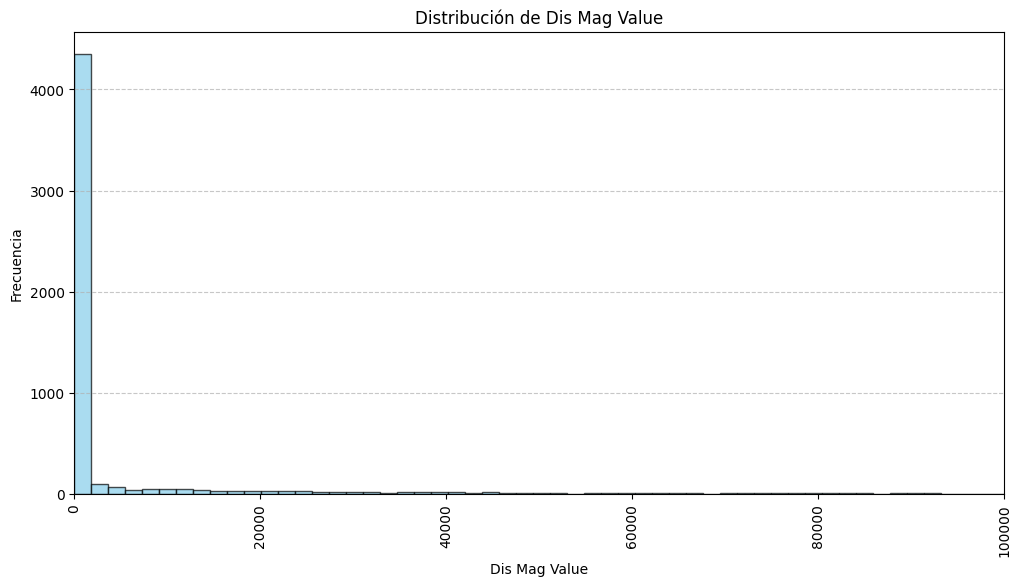

In [319]:
# value counts y sort by index
value_counts_sorted = df_flood['Dis Mag Value'].value_counts().sort_index()

# Histograma
plt.figure(figsize=(12, 6))
plt.hist(df_flood['Dis Mag Value'], bins=len(value_counts_sorted), edgecolor='black', color='skyblue', alpha=0.7)
plt.xlabel('Dis Mag Value')
plt.ylabel('Frecuencia')
plt.title('Distribución de Dis Mag Value')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# x-axis limits para zoom
plt.xlim(0, 100000)

plt.show()

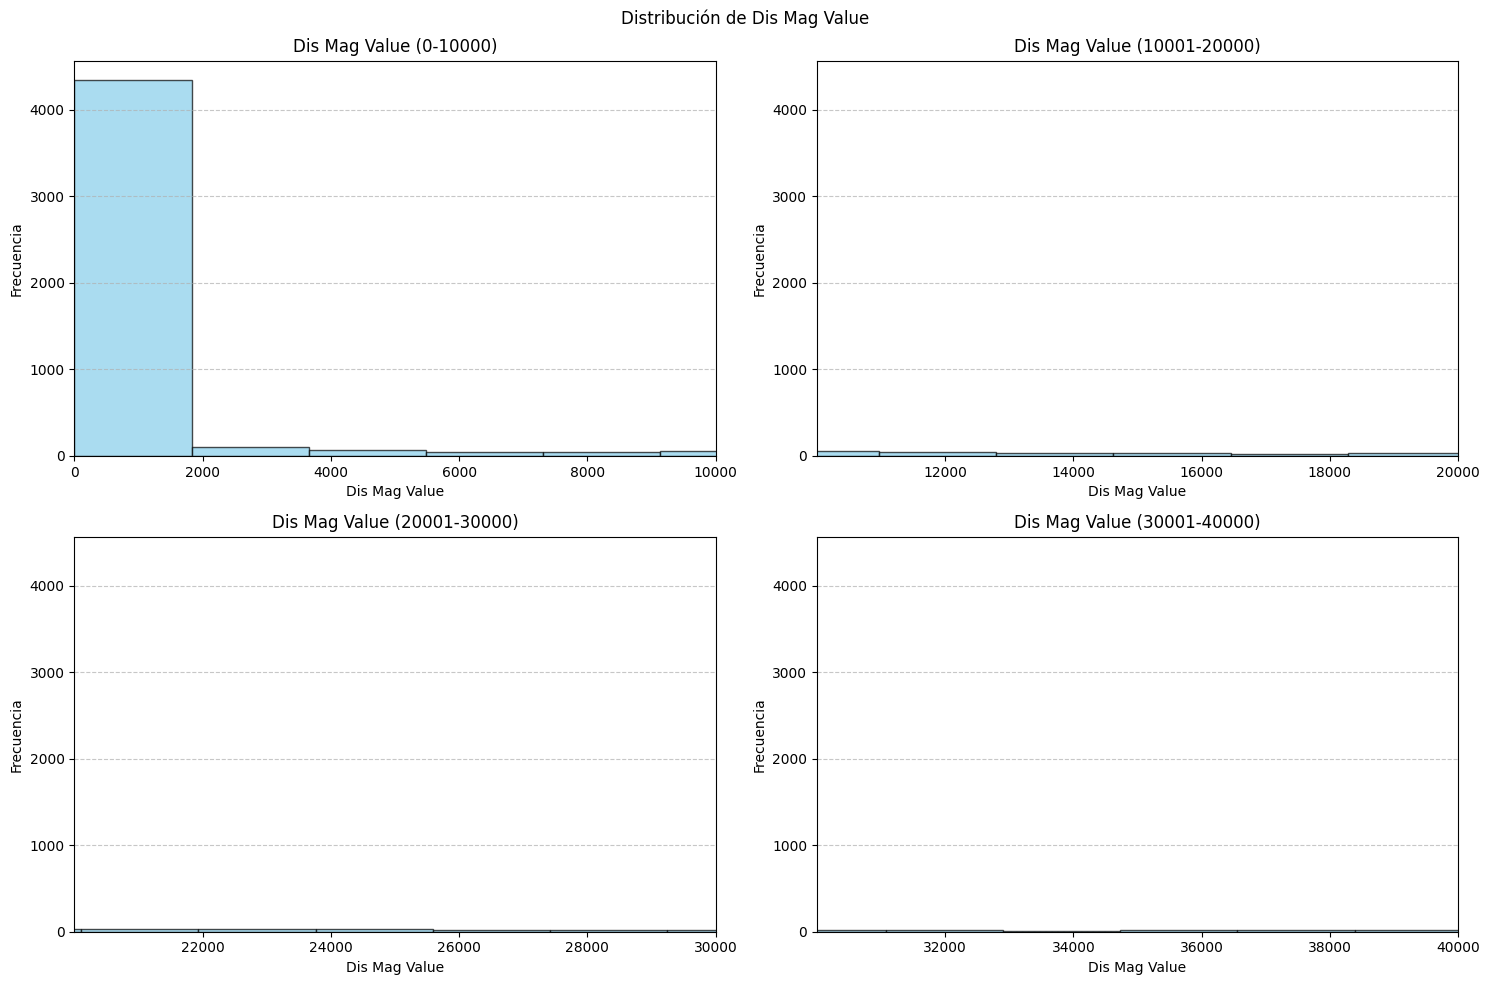

In [320]:
# Value counts y sort by index
value_counts_sorted = df_flood['Dis Mag Value'].value_counts().sort_index()

# Subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle('Distribución de Dis Mag Value')

# Rangos de zoom para cada subplot
zoom_ranges = [(0, 10000), (10001, 20000), (20001, 30000), (30001, 40000), (40001, 50000)]

# Sector segmentado por zoom
for i, ax in enumerate(axes.flat):
    lower_limit, upper_limit = zoom_ranges[i]
    ax.hist(df_flood['Dis Mag Value'], bins=len(value_counts_sorted), edgecolor='black', color='skyblue', alpha=0.7)
    ax.set_xlabel('Dis Mag Value')
    ax.set_ylabel('Frecuencia')
    ax.set_xlim(lower_limit, upper_limit)
    ax.set_title(f'Dis Mag Value ({lower_limit}-{upper_limit})')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [321]:
filter = df_flood['Dis Mag Value'] != 0
df_flood_filtered = df_flood[filter]
df_flood_filtered.head()

,Disaster Type,Disaster Subtype,Country,Region,Continent,Location,Origin,Associated Dis,Dis Mag Value,Dis Mag Scale,Start Year,Start Month,Start Day,End Year,End Month,End Day,Total Deaths,Total Affected,Total Damages Adj
39,Flood,Riverine flood,China,Eastern Asia,Asia,Guangzhou,NaN,NaN,3000,Km2,1915,0,0,1915,0,0,0,3000000,0
123,Flood,Unknown,China,Eastern Asia,Asia,NaN,NaN,NaN,150000,Km2,1935,0,0,1935,0,0,142000,10030000,0
630,Flood,Unknown,Algeria,Northern Africa,Africa,"Northeast, Tlemcen",NaN,NaN,770,Km2,1973,3,0,1973,3,0,21,146000,65913
632,Flood,Unknown,Ecuador,South America,Americas,NaN,NaN,NaN,15000,Km2,1973,2,0,1973,2,0,0,30000,0
782,Flood,Unknown,Ethiopia,Eastern Africa,Africa,Awash River Valley,NaN,NaN,18,Km2,1977,11,0,1977,11,0,7,16000,0


In [322]:
# mask = df_flood['Dis Mag Value'] != 0

# Calcular percentiles 25, 50 y 75 para Dis Mag Value, excluyendo 0

type1_threshold = np.percentile(df_flood_filtered['Dis Mag Value'], 25)
type2_threshold = np.percentile(df_flood_filtered['Dis Mag Value'], 50)
type3_threshold = np.percentile(df_flood_filtered['Dis Mag Value'], 75)

print(f'Umbral 1: {type1_threshold}')
print(f'Umbral 2: {type2_threshold}')
print(f'Umbral 3: {type3_threshold}')

Umbral 1: 4210.0
Umbral 2: 24681.0
Umbral 3: 84762.0


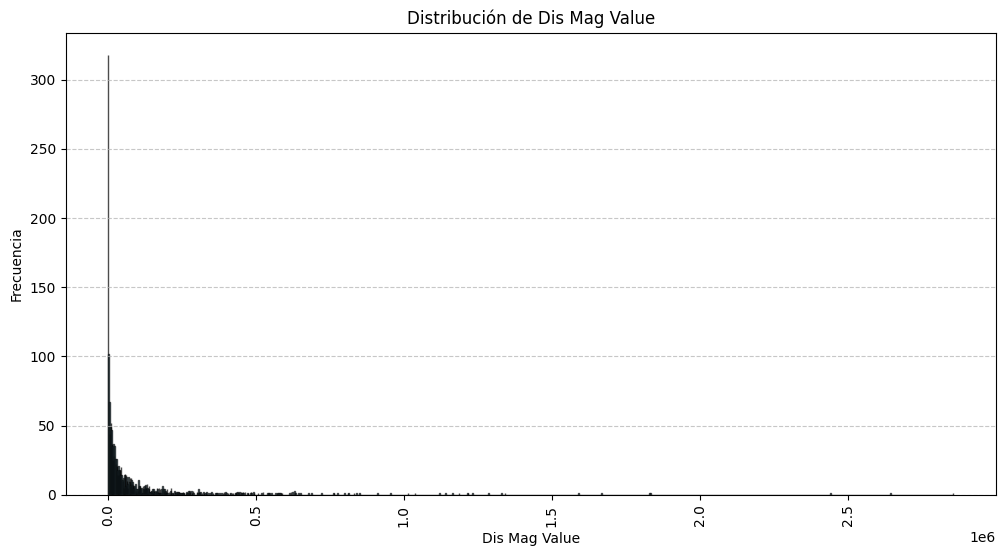

In [323]:
# value counts y sort by index
value_counts_sorted = df_flood_filtered['Dis Mag Value'].value_counts().sort_index()

# Histograma
plt.figure(figsize=(12, 6))
plt.hist(df_flood_filtered['Dis Mag Value'], bins=len(value_counts_sorted), edgecolor='black', color='skyblue', alpha=0.7)
plt.xlabel('Dis Mag Value')
plt.ylabel('Frecuencia')
plt.title('Distribución de Dis Mag Value')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# x-axis limits para zoom
# plt.xlim(0, 100000)

plt.show()

### Función para crear columna categórica de nivel de impacto: Flood Type

In [324]:
# Función previa que no considera valores nulos
def assign_flood_type(row):
    if row['Dis Mag Value'] < type1_threshold and row['Total Deaths'] < 100 and row['Total Affected'] < 10000 and row['Total Damages Adj'] < 1000000:
        return 'Low' # 1
    elif row['Dis Mag Value'] < type2_threshold and row['Total Deaths'] < 500 and row['Total Affected'] < 100000 and row['Total Damages Adj'] < 10000000:
        return 'Moderate' # 2
    elif row['Dis Mag Value'] < type3_threshold and row['Total Deaths'] < 1000 and row['Total Affected'] < 500000 and row['Total Damages Adj'] < 100000000:
        return 'High' # 3
    else:
        return 'Very High' # 4

In [325]:
df_flood_filtered['Flood Type'] = df_flood_filtered.apply(assign_flood_type, axis=1)
df_flood_filtered.head(10)

C:\Users\AleEng\AppData\Local\Temp\ipykernel_7984\1382504434.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flood_filtered['Flood Type'] = df_flood_filtered.apply(assign_flood_type, axis=1)


,Disaster Type,Disaster Subtype,Country,Region,Continent,Location,Origin,Associated Dis,Dis Mag Value,Dis Mag Scale,Start Year,Start Month,Start Day,End Year,End Month,End Day,Total Deaths,Total Affected,Total Damages Adj,Flood Type
39,Flood,Riverine flood,China,Eastern Asia,Asia,Guangzhou,NaN,NaN,3000,Km2,1915,0,0,1915,0,0,0,3000000,0,Very High
123,Flood,Unknown,China,Eastern Asia,Asia,NaN,NaN,NaN,150000,Km2,1935,0,0,1935,0,0,142000,10030000,0,Very High
630,Flood,Unknown,Algeria,Northern Africa,Africa,"Northeast, Tlemcen",NaN,NaN,770,Km2,1973,3,0,1973,3,0,21,146000,65913,High
632,Flood,Unknown,Ecuador,South America,Americas,NaN,NaN,NaN,15000,Km2,1973,2,0,1973,2,0,0,30000,0,Moderate
782,Flood,Unknown,Ethiopia,Eastern Africa,Africa,Awash River Valley,NaN,NaN,18,Km2,1977,11,0,1977,11,0,7,16000,0,Moderate
1556,Flood,Unknown,India,Southern Asia,Asia,"Brahmaputra, Dhemaji, North Lakhimpur, Jorhat,...",NaN,NaN,2600,Km2,1971,6,0,1971,6,0,0,130000,0,High
1830,Flood,Unknown,Mozambique,Eastern Africa,Africa,Zambesi valley,NaN,NaN,615,Km2,1978,3,0,1978,3,0,40,200000,282635,High
1983,Flood,Unknown,Saint Vincent and the Grenadines,Caribbean,Americas,NaN,NaN,NaN,140,Km2,1977,10,18,1977,10,18,0,0,0,Low
2061,Flood,Riverine flood,China,Eastern Asia,Asia,"Hubei province, West Shangai",NaN,NaN,12140,Km2,1980,9,2,1980,9,2,0,0,0,Moderate
2128,Flood,Unknown,Guinea,Western Africa,Africa,"Niany, Tieney, Sirakoro, Balandougoubal, Dougo...",NaN,NaN,25,Km2,1981,9,0,1981,9,0,0,5000,0,Low


In [326]:
df_flood_filtered.shape

(1777, 20)

### Codificación categórica a numérica

#### Convertir Flood Type a Destruction Level numérica con get_dummies

In [327]:
# Crear instancia de OneHotEncoder
# encoder = OneHotEncoder() # solo aplicar para variables de entrada X

# Hacer el get_dummies para la variable Destruction Level

# Ajustar y transformar la columna 'Flood Type' con el encoder OneHotEncoder()
# flood_type_encoded = encoder.fit_transform(df_flood_filtered[['Flood Type']]).toarray()

# Obtener valores únicos en columna 'Flood Type'
unique_flood_types = df_flood_filtered['Flood Type'].unique()

# Definir un diccionario de mapeo para las categorías en 'Flood Type' a valores numéricos
destruction_mapping = {'Low': 1, 'Moderate': 2, 'High': 3, 'Very High': 4}

# Crear una nueva columna 'Destruction Level' mapeando las categorías 'Flood Type' a valores numéricos
df_flood_filtered['Destruction Level'] = df_flood_filtered['Flood Type'].map(destruction_mapping)

# Aplicar get_dummies a columna 'Flood Type'. Se utiliza solo para la entrada X.
# destruction_encoded = pd.get_dummies(df_flood_filtered['Destruction Level'], prefix='Destruction')

# Concatenar el DataFrame codificado con el original
# df_flood_encoded = pd.concat([df_flood_filtered, destruction_encoded], axis=1)
# df_flood_encoded = pd.concat([df_flood_filtered], axis=1)
df_flood_filtered

# DataFrame actualizado
# print(df_flood_encoded.head())


C:\Users\AleEng\AppData\Local\Temp\ipykernel_7984\1038894599.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flood_filtered['Destruction Level'] = df_flood_filtered['Flood Type'].map(destruction_mapping)


,Disaster Type,Disaster Subtype,Country,Region,Continent,Location,Origin,Associated Dis,Dis Mag Value,Dis Mag Scale,Start Year,Start Month,Start Day,End Year,End Month,End Day,Total Deaths,Total Affected,Total Damages Adj,Flood Type,Destruction Level
39,Flood,Riverine flood,China,Eastern Asia,Asia,Guangzhou,NaN,NaN,3000,Km2,1915,0,0,1915,0,0,0,3000000,0,Very High,4
123,Flood,Unknown,China,Eastern Asia,Asia,NaN,NaN,NaN,150000,Km2,1935,0,0,1935,0,0,142000,10030000,0,Very High,4
630,Flood,Unknown,Algeria,Northern Africa,Africa,"Northeast, Tlemcen",NaN,NaN,770,Km2,1973,3,0,1973,3,0,21,146000,65913,High,3
632,Flood,Unknown,Ecuador,South America,Americas,NaN,NaN,NaN,15000,Km2,1973,2,0,1973,2,0,0,30000,0,Moderate,2
782,Flood,Unknown,Ethiopia,Eastern Africa,Africa,Awash River Valley,NaN,NaN,18,Km2,1977,11,0,1977,11,0,7,16000,0,Moderate,2
1556,Flood,Unknown,India,Southern Asia,Asia,"Brahmaputra, Dhemaji, North Lakhimpur, Jorhat,...",NaN,NaN,2600,Km2,1971,6,0,1971,6,0,0,130000,0,High,3
1830,Flood,Unknown,Mozambique,Eastern Africa,Africa,Zambesi valley,NaN,NaN,615,Km2,1978,3,0,1978,3,0,40,200000,282635,High,3
1983,Flood,Unknown,Saint Vincent and the Grenadines,Caribbean,Americas,NaN,NaN,NaN,140,Km2,1977,10,18,1977,10,18,0,0,0,Low,1
2061,Flood,Riverine flood,China,Eastern Asia,Asia,"Hubei province, West Shangai",NaN,NaN,12140,Km2,1980,9,2,1980,9,2,0,0,0,Moderate,2
2128,Flood,Unknown,Guinea,Western Africa,Africa,"Niany, Tieney, Sirakoro, Balandougoubal, Dougo...",NaN,NaN,25,Km2,1981,9,0,1981,9,0,0,5000,0,Low,1


#### Revisión df_flood_filtered

In [328]:
df_flood_filtered.shape

(1777, 21)

In [329]:
len(df_flood_filtered)

1777

In [330]:
df_flood_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1777 entries, 39 to 16089
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Disaster Type      1777 non-null   object
 1   Disaster Subtype   1777 non-null   object
 2   Country            1777 non-null   object
 3   Region             1777 non-null   object
 4   Continent          1777 non-null   object
 5   Location           1763 non-null   object
 6   Origin             1513 non-null   object
 7   Associated Dis     514 non-null    object
 8   Dis Mag Value      1777 non-null   int64 
 9   Dis Mag Scale      1777 non-null   object
 10  Start Year         1777 non-null   int64 
 11  Start Month        1777 non-null   int64 
 12  Start Day          1777 non-null   int64 
 13  End Year           1777 non-null   int64 
 14  End Month          1777 non-null   int64 
 15  End Day            1777 non-null   int64 
 16  Total Deaths       1777 non-null   int64

In [331]:
df_flood_filtered.columns

Index(['Disaster Type', 'Disaster Subtype', 'Country', 'Region', 'Continent',
       'Location', 'Origin', 'Associated Dis', 'Dis Mag Value',
       'Dis Mag Scale', 'Start Year', 'Start Month', 'Start Day', 'End Year',
       'End Month', 'End Day', 'Total Deaths', 'Total Affected',
       'Total Damages Adj', 'Flood Type', 'Destruction Level'],
      dtype='object')

In [332]:
df_flood_filtered['Destruction Level']

39       4
123      4
630      3
632      2
782      2
1556     3
1830     3
1983     1
2061     2
2128     1
2286     1
2314     4
2315     3
2319     2
2325     3
2329     3
2331     3
2333     4
2343     4
2350     4
2351     2
2353     4
2363     2
2365     4
2370     4
2388     4
2395     3
2403     3
2424     4
2459     4
2466     2
2483     3
2543     2
2546     1
2550     4
2569     2
2570     4
2582     3
2589     2
2605     2
2700     2
2767     2
3047     3
3050     3
3080     2
3081     3
3083     4
3084     4
3091     4
3092     4
3109     3
3112     2
3121     2
3141     2
3145     3
3159     4
3162     2
3193     3
3221     4
3231     3
3295     1
3373     4
3395     3
3446     2
3473     1
3537     4
3571     1
3574     2
3575     2
3580     2
3581     2
3582     2
3583     4
3584     3
3594     2
3595     4
3642     2
3645     1
3683     2
3689     2
3732     3
3749     1
3794     4
3812     4
3837     4
3838     4
3839     4
3887     1
3897     4
3908     4
3915     1

In [333]:
df_flood_filtered['Destruction Level'].isnull().sum()

0

#### Imputación de nulos en columna salida (y) Destruction Level con Simple Imputer

In [334]:
# Imputar nulos en la columna de salida (y) que es Destruction Level
# df_flood_filtered['Destruction Level'] = SimpleImputer(missing_values=0, strategy='most_frequent').fit_transform(df_flood[['Destruction Level']])
# df_flood_filtered['Destruction Level']
# Se prueba a cambiar np_nan por 0 
# borrar en lugar de imputar
# df = df.dropna('Flood Type')

In [335]:
df_flood_filtered['Flood Type'].isna().sum()
df_flood_filtered['Flood Type'].unique()
len(df_flood_filtered['Flood Type'])

1777

### EDA Visualizaciones de 'Destruction Level' o Nivel de Destrucción

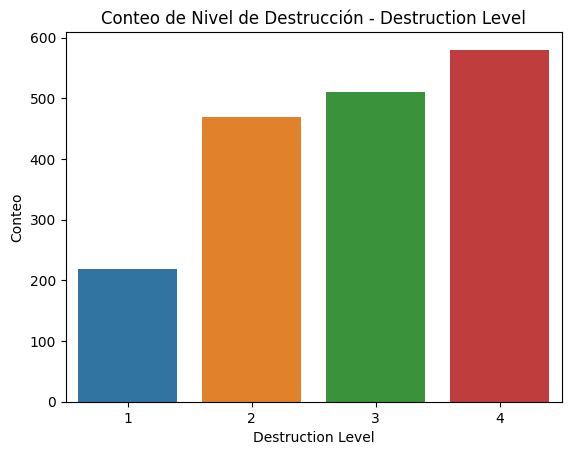

In [336]:
sns.countplot(data=df_flood_filtered, x='Destruction Level')
plt.title('Conteo de Nivel de Destrucción - Destruction Level')
plt.xlabel('Destruction Level')
plt.ylabel('Conteo')
plt.show()

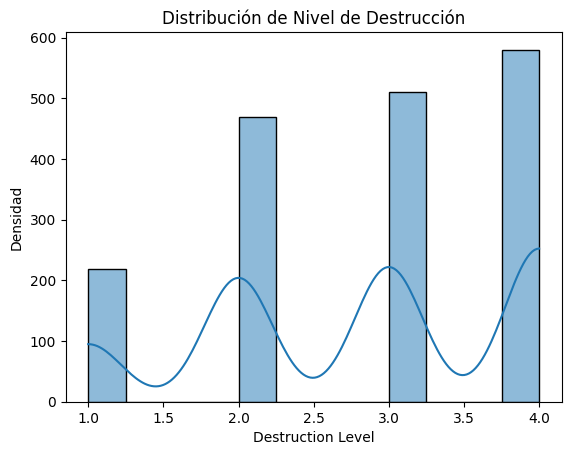

In [337]:
sns.histplot(data=df_flood_filtered, x='Destruction Level', kde=True)
plt.title(f'Distribución de Nivel de Destrucción')
plt.xlabel('Destruction Level')
plt.ylabel('Densidad')
plt.show()

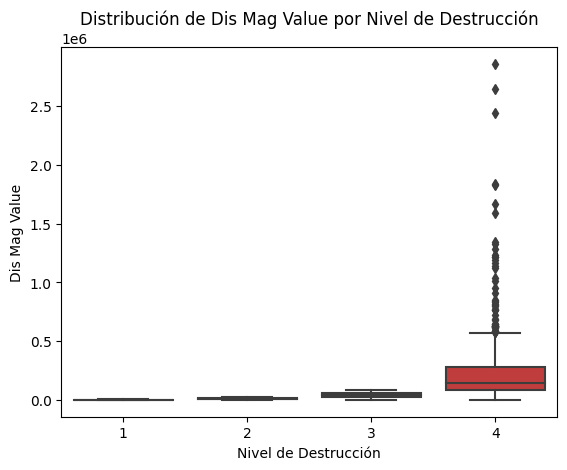

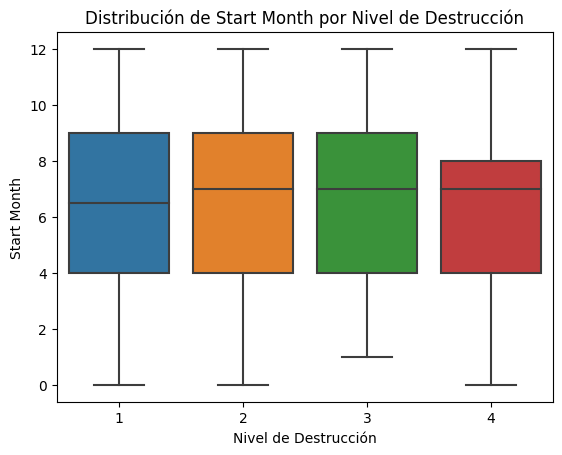

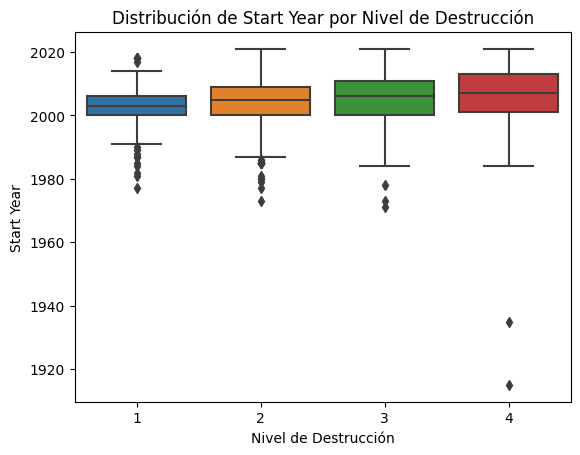

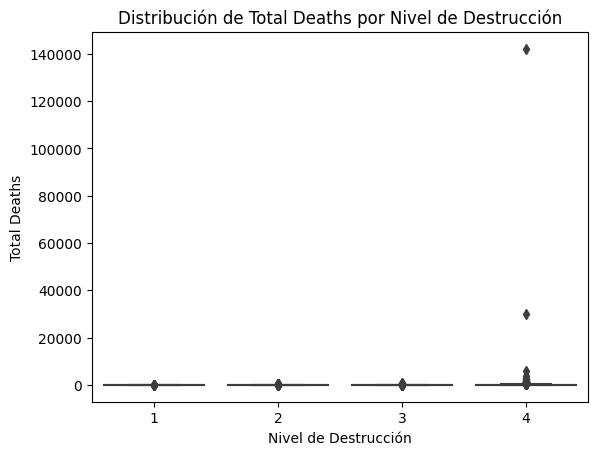

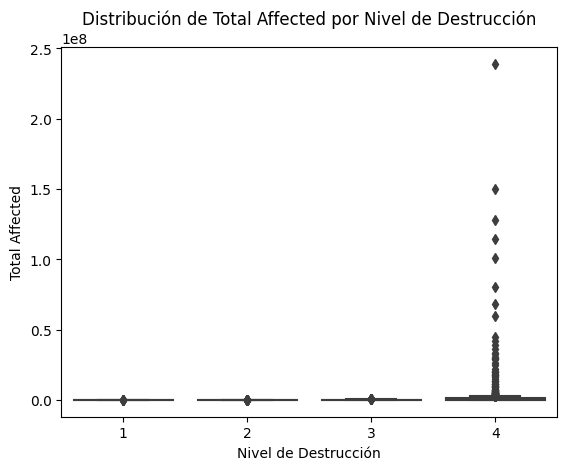

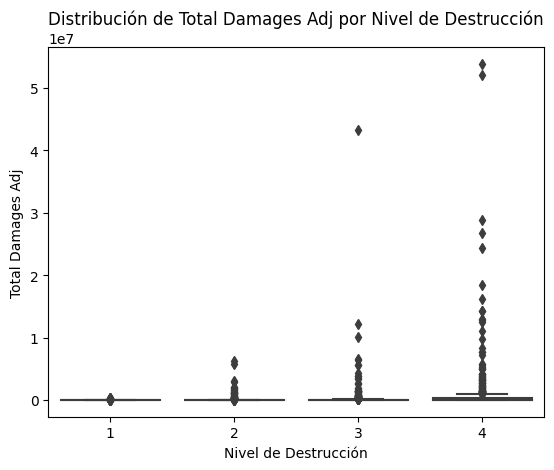

In [338]:
num_cols = ['Dis Mag Value', 'Start Month', 'Start Year', 'Total Deaths', 'Total Affected', 'Total Damages Adj']
for col in num_cols:
    sns.boxplot(data=df_flood_filtered, x='Destruction Level', y=col)
    plt.title(f'Distribución de {col} por Nivel de Destrucción')
    plt.xlabel('Nivel de Destrucción')
    plt.ylabel(col)
    plt.show()

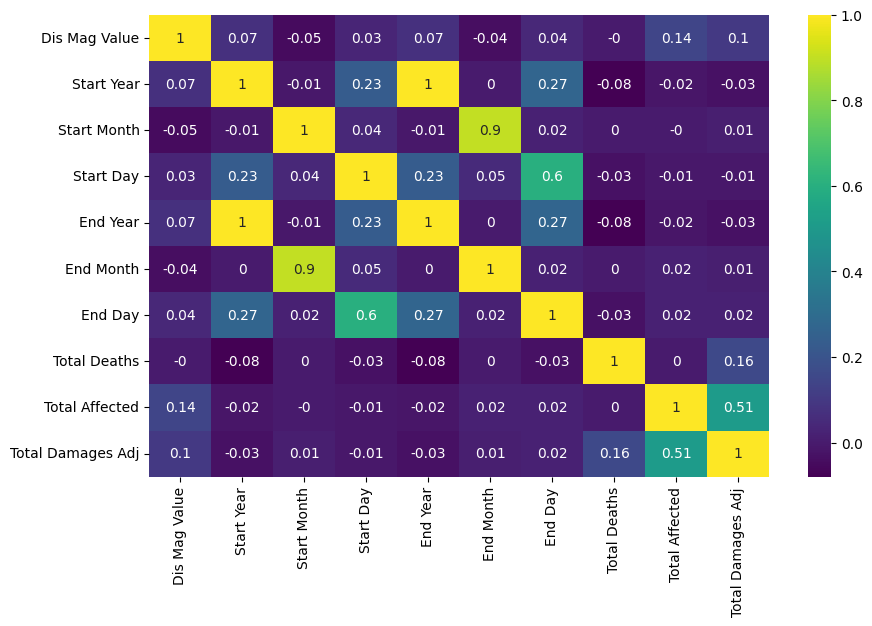

In [339]:
plt.figure(figsize=(10, 6))
df_corr = df_flood.corr(numeric_only=True).round(2)
sns.heatmap(df_corr, cmap='viridis', annot=True);

<Axes: xlabel='Dis Mag Value', ylabel='Destruction Level'>

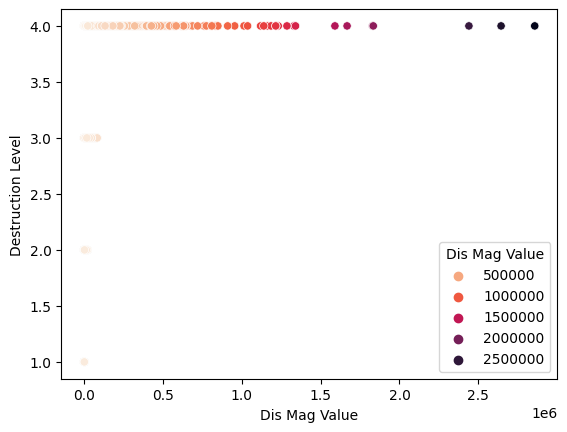

In [340]:
sns.scatterplot(data=df_flood_filtered, x='Dis Mag Value', y='Destruction Level', hue='Dis Mag Value', palette='rocket_r')

<Axes: xlabel='Start Month', ylabel='Destruction Level'>

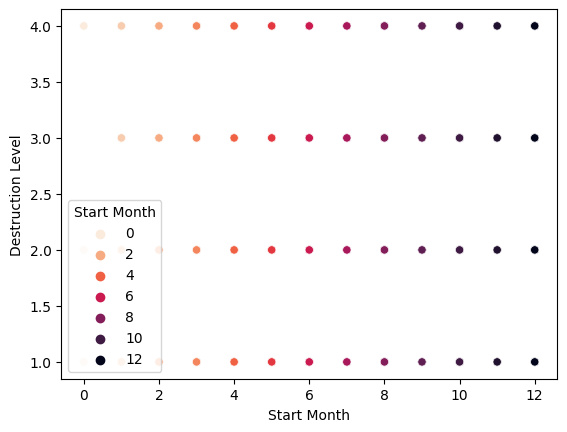

In [341]:
sns.scatterplot(data=df_flood_filtered, x='Start Month', y='Destruction Level', hue='Start Month', palette='rocket_r')

<Axes: xlabel='Start Year', ylabel='Destruction Level'>

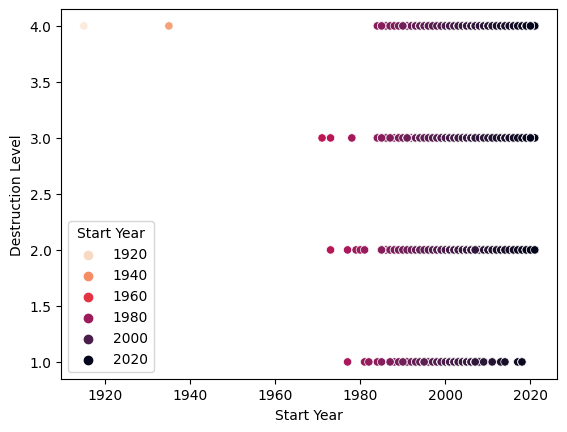

In [342]:
sns.scatterplot(data=df_flood_filtered, x='Start Year', y='Destruction Level', hue='Start Year', palette='rocket_r')

<Axes: xlabel='Total Deaths', ylabel='Destruction Level'>

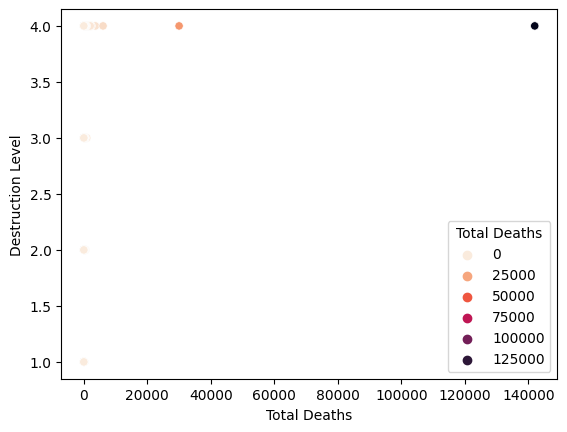

In [343]:
sns.scatterplot(data=df_flood_filtered, x='Total Deaths', y='Destruction Level', hue='Total Deaths', palette='rocket_r')

<Axes: xlabel='Total Affected', ylabel='Destruction Level'>

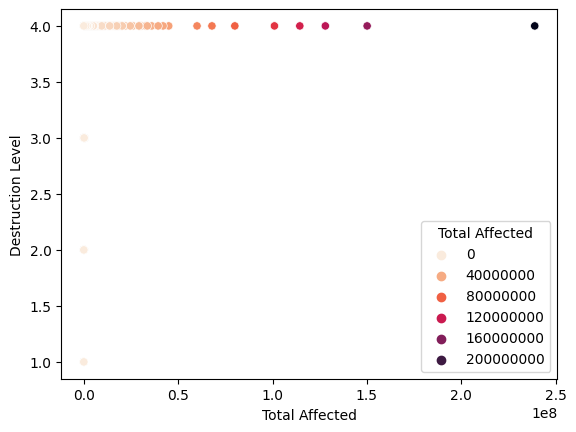

In [344]:
sns.scatterplot(data=df_flood_filtered, x='Total Affected', y='Destruction Level', hue='Total Affected', palette='rocket_r')

<Axes: xlabel='Total Damages Adj', ylabel='Destruction Level'>

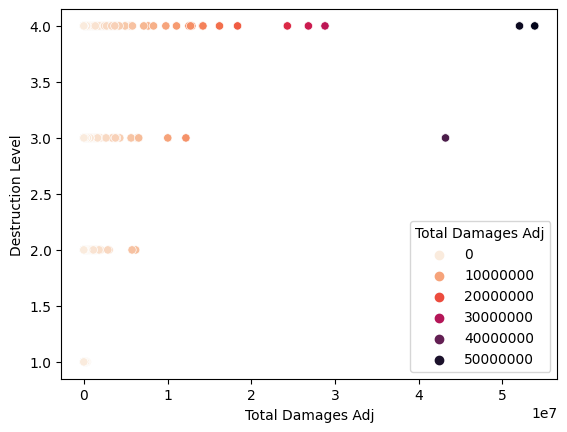

In [345]:
sns.scatterplot(data=df_flood_filtered, x='Total Damages Adj', y='Destruction Level', hue='Total Damages Adj', palette='rocket_r')

* La primera visualización muestra la relación entre 'Dis Mag Value' y 'Destruction Level'. Sugiere que existe una fuerte correlación entre estas dos variables, ya que el 'Nivel de destrucción' tiende a aumentar con un 'Valor de Magnitud de Desastre' más alto.
* La segunda visualización muestra la relación entre el 'Mes de inicio' y el 'Nivel de destrucción'. Indica que podría haber alguna variación en el 'Nivel de destrucción' entre diferentes meses, aunque el patrón no está explícitamente claro.
* La tercera visualización representa la relación entre el 'Año de inicio' y el 'Nivel de destrucción'. Sugiere que podría haber algunas tendencias o patrones en el 'Nivel de destrucción' a lo largo de los años, aunque una visión más específica requeriría un análisis más profundo, dado que influye la capacidad de recolección de datos por el incremento y mejora en conocimientos estadísticos e implementación de nuevas tecnologías.
* La cuarta visualización muestra la relación entre 'Muertes Totales' y 'Nivel de Destrucción'. Indica que un 'Total de muertes' más alto generalmente corresponde a un 'Nivel de destrucción' más alto.
* La quinta visualización muestra la relación entre 'Total de afectados' y 'Nivel de destrucción'. Sugiere que un 'total afectado' más alto tiende a asociarse con un 'nivel de destrucción' más alto.
* La sexta visualización representa la relación entre 'Total Damages Adj' y 'Destruction Level'. Indica que un 'Ajuste total de daños' más alto generalmente corresponde a un 'Nivel de destrucción' más alto.

### Pivot Tables

In [346]:
df_floodresult_pivot_table = pd.pivot_table(df_flood_filtered, index='Destruction Level', values=['Dis Mag Value', 'Total Deaths', 'Total Affected', 'Total Damages Adj'], aggfunc='min')
df_floodresult_pivot_table

,Dis Mag Value,Total Affected,Total Damages Adj,Total Deaths
Destruction Level,,,,
1,2,0,0,0
2,3,0,0,0
3,4,0,0,0
4,120,0,0,0


In [347]:
df_floodresult_pivot_table = pd.pivot_table(df_flood_filtered, index='Destruction Level', values=['Dis Mag Value', 'Total Deaths', 'Total Affected', 'Total Damages Adj'], aggfunc='max')
df_floodresult_pivot_table

,Dis Mag Value,Total Affected,Total Damages Adj,Total Deaths
Destruction Level,,,,
1,4170,9855,382046,98
2,24415,99185,6192575,498
3,84662,498924,43201120,921
4,2857000,238973000,53860097,142000


In [348]:
df_floodresult_pivot_table = pd.pivot_table(df_flood_filtered, index='Destruction Level', values=['Dis Mag Value', 'Total Deaths', 'Total Affected', 'Total Damages Adj'], aggfunc='sum')
df_floodresult_pivot_table

,Dis Mag Value,Total Affected,Total Damages Adj,Total Deaths
Destruction Level,,,,
1,278205,438092,3422569,2281
2,4659410,7489867,51888782,12958
3,19725722,45573302,156203475,16207
4,138932750,2019715249,546029546,252244


In [349]:
df_floodresult_pivot_table = pd.pivot_table(df_flood_filtered, index='Destruction Level', values=['Dis Mag Value', 'Total Deaths', 'Total Affected', 'Total Damages Adj'], aggfunc='mean')
df_floodresult_pivot_table

,Dis Mag Value,Total Affected,Total Damages Adj,Total Deaths
Destruction Level,,,,
1,1276.169725,2.009596e+03,15699.857798,10.463303
2,9934.776119,1.596987e+04,110637.061834,27.628998
3,38677.886275,8.935942e+04,306281.323529,31.778431
4,239539.224138,3.482268e+06,941430.251724,434.903448


In [350]:
df_floodresult_pivot_table = pd.pivot_table(df_flood_filtered, index='Destruction Level', values=['Dis Mag Value', 'Total Deaths', 'Total Affected', 'Total Damages Adj'], aggfunc='median')
df_floodresult_pivot_table

,Dis Mag Value,Total Affected,Total Damages Adj,Total Deaths
Destruction Level,,,,
1,920,1200,0,4
2,9280,6000,0,8
3,37895,25000,0,11
4,140000,119255,12581,27


## Preparar X y

In [351]:
X = df_flood_filtered.drop('Destruction Level', axis=1).select_dtypes(exclude=['object'])  # Excluir columnas categóricas
y = df_flood_filtered['Destruction Level'] # Quitar Destruction Level y poner los binarios de Flood Type

## train_test_split

In [352]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print(f"train: {X_train.shape}, {y_train.shape}")
print(f"test: {X_test.shape}, {y_test.shape}")

train: (1421, 10), (1421,)
test: (356, 10), (356,)


### SMOTE Balanceo de clases

In [353]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print(f"original: {X_train.shape} {y_train.shape}")
print(f"resampled: {X_train_res.shape} {y_train_res.shape}")

# comprobar que se han balanceado las clases
y_train_res.value_counts()

original: (1421, 10) (1421,)
resampled: (1876, 10) (1876,)


4    469
3    469
1    469
2    469
Name: Destruction Level, dtype: int64

# Modelo

## Definir el Modelo

#### Pipeline columnas numéricas

In [354]:
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputar valores faltantes usando most_frequent
    ('scaler', StandardScaler()),  # Escalar características numéricas
    ('classifier', RandomForestClassifier()) # Modelo elegido a partir de validación al ser el mejor del ranking
])

## Ejecución de pipeline

### Entrenar el modelo

In [355]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('scaler', StandardScaler()),
                ('classifier', RandomForestClassifier())])

#### Explicación de pipeline:
Incluye los siguientes pasos: SimpleImputer, StandardScaler y RandomForestClassifier.
* SimpleImputer para manejar los valores faltantes en los datos.
* StandardScaler para estandarizar las características numéricas, asegurando que tengan una media cero y una varianza unitaria.
* RandomForestClassifier es el modelo de clasificación elegido.

## Ejecución de pipeline

In [356]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

## Guardar pipeline

Se usa joblib para guardar modelos o pipelines.

Serializa un modelo o pipeline (objeto Python) a una secuencia de bytes que se almacenan en un archivo

* joblib.dump()
* joblib.load()

In [357]:
# pickle .pkl o .joblib
joblib.dump(pipeline, 'pipelineRFC_Flood_DestructionLvl.pkl') # más genérico
joblib.dump(pipeline, 'pipelineRFC_Flood_DestructionLvl.joblib') # más eficiente con muchos datos

['pipelineRFC_Flood_DestructionLvl.joblib']

## Cargar pipeline

In [358]:
pipeline = joblib.load('pipelineRFC_Flood_DestructionLvl.joblib')
pipeline.predict(X_test)[:10]

array([4, 3, 2, 4, 1, 4, 2, 3, 2, 4], dtype=int64)

# Evaluar Modelo

### Predicción y_pred

In [359]:
y_pred = pipeline.predict(X_test)

In [360]:
y_pred.shape

(356,)

# Predicciones

### Entrada

In [361]:
# Predicción Low: 
# Predicción Moderate:
# Predicción High: 
# Predicción Very High: 

### Predicción X_destruction_controlled
2024-2027, máximo de columnas entrada X, valores controlados bajo umbrales

In [362]:
X_destruction_controlled= pd.DataFrame({'Dis Mag Value': [10, 4500, 26000, 90000],
                             'Start Year': [2024, 2025, 2026, 2027],
                             'Start Month': [1, 5, 8, 12],
                             'Start Day': [6, 16, 24, 30],
                             'End Year': [2024, 2025, 2026, 2027],
                             'End Month': [1, 5, 9, 1],
                             'End Day': [8, 21, 4, 28],
                             'Total Deaths': [70, 250, 800, 10000],
                             'Total Affected': [5000, 25000, 300000, 1000000],
                             'Total Damages Adj': [200000, 5000000, 12000000, 101000000]
                             })

X_destruction_controlled['Destruction Level'] = pipeline.predict(X_destruction_controlled)
X_destruction_controlled

,Dis Mag Value,Start Year,Start Month,Start Day,End Year,End Month,End Day,Total Deaths,Total Affected,Total Damages Adj,Destruction Level
0,10,2024,1,6,2024,1,8,70,5000,200000,2
1,4500,2025,5,16,2025,5,21,250,25000,5000000,2
2,26000,2026,8,24,2026,9,4,800,300000,12000000,3
3,90000,2027,12,30,2027,1,28,10000,1000000,101000000,4


### Predicción X_destruction_outliers
2024-2027, máximo de columnas entrada X, valores con outliers en últimas filas

In [363]:
X_destruction_outliers = pd.DataFrame({'Dis Mag Value': [10, 4500, 26000, 2], # se cambió solo 90000 a 2
                             'Start Year': [2024, 2025, 2026, 2027],
                             'Start Month': [1, 5, 8, 12],
                             'Start Day': [6, 16, 24, 30],
                             'End Year': [2024, 2025, 2026, 2027],
                             'End Month': [1, 5, 9, 1],
                             'End Day': [8, 21, 4, 28],
                             'Total Deaths': [70, 250, 800, 10], # se quitaron 0s
                             'Total Affected': [5000, 25000, 300000, 10], # se quitaron 0s
                             'Total Damages Adj': [200000, 5000000, 12000000, 10] # se quitaron 0s
                             })

X_destruction_outliers['Destruction Level'] = pipeline.predict(X_destruction_outliers)
X_destruction_outliers

,Dis Mag Value,Start Year,Start Month,Start Day,End Year,End Month,End Day,Total Deaths,Total Affected,Total Damages Adj,Destruction Level
0,10,2024,1,6,2024,1,8,70,5000,200000,2
1,4500,2025,5,16,2025,5,21,250,25000,5000000,2
2,26000,2026,8,24,2026,9,4,800,300000,12000000,3
3,2,2027,12,30,2027,1,28,10,10,10,1


### Predicción X_destruction_testC
2024-2027, máximo de columnas entrada X, valores reducidos para probar Low o 1

In [364]:
X_destruction_testC = pd.DataFrame({
    'Dis Mag Value': [5, 3000, 1500, 1],  # Valores 'Dis Mag Value' reducidos
    'Start Year': [2024, 2025, 2026, 2027],
    'Start Month': [1, 5, 8, 12],
    'Start Day': [6, 16, 24, 30],
    'End Year': [2024, 2025, 2026, 2027],
    'End Month': [1, 5, 9, 1],
    'End Day': [8, 21, 4, 28],
    'Total Deaths': [35, 150, 2, 5],  # Valores 'Total Deaths' reducidos
    'Total Affected': [2500, 12000, 8, 5],  # Valores 'Total Affected' reducidos
    'Total Damages Adj': [100000, 3000000, 6, 5]  # Valores 'Total Damages Adj' reducidos
})

X_destruction_testC['Destruction Level'] = pipeline.predict(X_destruction_testC)
X_destruction_testC

,Dis Mag Value,Start Year,Start Month,Start Day,End Year,End Month,End Day,Total Deaths,Total Affected,Total Damages Adj,Destruction Level
0,5,2024,1,6,2024,1,8,35,2500,100000,2
1,3000,2025,5,16,2025,5,21,150,12000,3000000,2
2,1500,2026,8,24,2026,9,4,2,8,6,1
3,1,2027,12,30,2027,1,28,5,5,5,1


Realizamos un test A y B, el primero con valores acordes a los umbrales y el segundo con algunos valores outliers en las últimas filas de entradas seleccionadas para controlar si la predicción es acertada o no.

In [365]:
# pipeline.fit(X_destruction_controlled[['Dis Mag Value']], y_destruction_controlled)
# pipeline.fit(X_destruction_outliers[['Dis Mag Value']], y_destruction_outliers)

# Prueba introducieno valores
X_destruction_controlled['Destruction Level'] = [2, 3, 3, 4]
X_destruction_outliers['Destruction Level'] = [2, 3, 3, 1]
X_destruction_testC['Destruction Level'] = [1, 3, 4, 1]

# Separaar features y variables y target para los distintos datasets de testeo
X_controlled = X_destruction_controlled[['Dis Mag Value']]
y_controlled = X_destruction_controlled['Destruction Level']

X_outliers = X_destruction_outliers[['Dis Mag Value']]
y_outliers = X_destruction_outliers['Destruction Level']

X_testC = X_destruction_testC[['Dis Mag Value']]
y_testC = X_destruction_testC['Destruction Level']

pipeline = RandomForestClassifier()
pipeline.fit(X_controlled, y_controlled)

# Predict on the controlled data
y_controlled_pred = pipeline.predict(X_controlled)

# Predict on the outliers data
y_outliers_pred = pipeline.predict(X_outliers)

# Predecir sobre los valores reducidos (tendencia a low)
y_testC_pred = pipeline.predict(X_testC)

Comparar test A: y_controlled_pred con y_controlled y  test B: y_outliers_pred con y_outliers y test C: y_controlled_testC con y_testC para evaluar el rendimiento de las predicciones en los conjuntos de datos controlados y de valores atípicos.

# Validaciones

## Reporte de Clasificación

El informe de clasificación proporciona un resumen detallado del rendimiento del modelo en cada clase (en este caso, cada 'Destruction Level') para los conjuntos de datos controlados y atípicos. El informe incluye métricas como precisión, recall y f1-score, que son medidas de la precisión y la integridad del modelo para cada clase.

In [366]:
# Evaluar desempeño del dataset controlado
print("Dataset Controlado o Test A:")
print(classification_report(y_controlled, y_controlled_pred))

# Evaluar desempeño del dataset con outliers
print("Outliers Dataset o Test B:")
print(classification_report(y_outliers, y_outliers_pred))

# Evaluar desempeño del dataset con outliers
print("Test C Dataset o Test C:")
print(classification_report(y_testC, y_testC_pred))

Dataset Controlado o Test A:
              precision    recall  f1-score   support

           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         1

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4

Outliers Dataset o Test B:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.50      1.00      0.67         1
           3       1.00      1.00      1.00         2

    accuracy                           0.75         4
   macro avg       0.50      0.67      0.56         4
weighted avg       0.62      0.75      0.67         4

Test C Dataset o Test C:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00     

c:\Users\AleEng\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\AleEng\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\AleEng\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

1. Conjunto de datos controlado:

* Precisión: Esto mide la proporción de predicciones positivas verdaderas (instancias de una clase predichas correctamente) de todas las predicciones positivas para cada clase. En este caso, el modelo logró una precisión de 1,00 para todas las clases (2, 3 y 4), lo que indica que todas las instancias previstas de estas clases eran correctas.

* Recall: Esto mide la proporción de predicciones positivas verdaderas de todas las instancias reales de una clase. La recuperación de 1.00 para todas las clases significa que el modelo identificó correctamente todas las instancias de estas clases.

* f1-score: La puntuación F1 es la media armónica de precisión y recuperación y proporciona un equilibrio entre las dos. Es útil cuando hay un desequilibrio entre el número de instancias en diferentes clases. La puntuación F1 de 1,00 para todas las clases indica un rendimiento excelente tanto en precisión como en recuperación.

* Soporte: el soporte representa el número de instancias reales de cada clase en el conjunto de datos. Para el conjunto de datos controlado, hay cuatro instancias en total.

* Precisión: la precisión general del modelo en el conjunto de datos controlado es 1,00, lo que significa que predijo correctamente todas las instancias.

2.- Conjunto de datos de valores atípicos:

 * Precisión: la precisión para la clase 1 es 0,00, lo que indica que el modelo no predijo correctamente ninguna instancia de esta clase. Para la clase 2, la precisión es 0,50, lo que significa que la mitad de las instancias pronosticadas fueron correctas. La precisión para la clase 3 es 1,00, lo que indica que todas las instancias predichas de esta clase fueron correctas.

* Recall: el recuerdo para la clase 1 es 0,00, lo que indica que el modelo no identificó correctamente ninguna instancia de esta clase. Para la clase 2 y la clase 3, la recuperación es 1,00, lo que significa que el modelo identificó correctamente todas las instancias de estas clases.

* f1-score: la puntuación F1 para la clase 1 es 0,00, lo que refleja la falta de predicciones positivas verdaderas. Para la clase 2, la puntuación F1 es 0,67, que es un equilibrio entre precisión y recuperación. La puntuación F1 para la clase 3 es 1,00, lo que indica un rendimiento excelente.

* Soporte: el soporte representa el número de instancias reales de cada clase en el conjunto de datos. Para el conjunto de datos de valores atípicos, hay cuatro instancias en total.

* Precisión: la precisión general del modelo en el conjunto de datos de valores atípicos es de 0,75, lo que significa que predijo correctamente 3 de 4 instancias.

### Conclusión del reporte de clasificación

Interpretación:
El modelo funciona extremadamente bien en el conjunto de datos controlado, logrando una precisión, recall y f1-score perfectos para todas las clases. Esto indica que el modelo predijo con precisión todas las instancias de cada clase y no hubo predicciones falsas positivas o falsas negativas.

Por otro lado, el rendimiento del modelo en el conjunto de datos de valores atípicos no es tan sólido. Predijo correctamente todas las instancias de la clase 3 (alta precisión, recall y f1-score), pero tuvo problemas con la clase 1 y no pudo hacer predicciones correctas. La puntuación F1 para la clase 2 es moderada, lo que indica un compromiso entre precisión y recuperación. En general, el modelo logró una precisión del 75 % en el conjunto de datos de valores atípicos.

Es importante tener en cuenta que el tamaño pequeño del conjunto de datos puede afectar las métricas de evaluación. En escenarios del mundo real, es común tener conjuntos de datos desequilibrados, que pueden requerir técnicas adicionales como el aumento de datos o la ponderación de clases para abordar el desequilibrio y mejorar el rendimiento del modelo.

En resumen, el modelo funciona excepcionalmente bien en el conjunto de datos controlado, pero muestra margen de mejora en el conjunto de datos de valores atípicos, especialmente para la clase 1. Es posible que se necesiten datos adicionales y ajustes del modelo para mejorar su rendimiento en el manejo de valores atípicos.

### Evaluación con mae, rmse y r2

In [367]:
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("Coefficient of Determination (R^2):", r2)

Mean Absolute Error (MAE): 0.025280898876404494
Root Mean Squared Error (RMSE): 0.158999682000954
Coefficient of Determination (R^2): 0.9742582371230929


#### Resultados de mae, rmse y r2
* Los valores varían cada vez que se vuelve a cargar el notebook

Mean Absolute Error (MAE): 0.006024096385542169
+ El MAE representa la diferencia absoluta promedio entre los valores pronosticados y los valores reales. En este caso, la diferencia absoluta promedio es muy pequeña, lo que indica que las predicciones del modelo son, en promedio, muy cercanas a los valores reales.


Error cuadrático medio (RMSE): 0.08800719732732863
* El RMSE mide la desviación estándar de los residuos, que representa la distancia promedio entre los valores predichos y los valores reales. El valor RMSE de 0,0718 indica que, en promedio, los valores pronosticados están muy cerca de los valores reales.


Coeficiente de Determinación (R^2): 0.9921474519014535

* La puntuación R^2, también conocida como coeficiente de determinación, mide la proporción de varianza en la variable dependiente que puede ser explicada por las variables independientes. Un valor de 0,9947 indica que el modelo explica aproximadamente el 99,47% de la varianza de la variable objetivo. Esto sugiere que el modelo funciona muy bien al capturar los patrones y tendencias subyacentes en los datos.

El informe de clasificación proporciona métricas de evaluación para el modelo RandomForestClassifier.
La precisión, el recuerdo (recall) y la puntuación F1 (f1-score) se informan para cada clase (1, 2, 3, 4), junto con el soporte (número de muestras) para cada clase.
También se informa la precisión del modelo: 1, lo que indica la corrección general de las predicciones.
Las métricas de macro avg o macropromedio y weighted avg o promedio ponderado proporcionan medidas de rendimiento agregadas en todas las clases.

# Conclusiones de la versión 4 o Test D

## Sobre resultados del modelo y comparación con versión 4

De acuerdo al reporte de clasificación, los resultados de la evaluación indican que el modelo RandomForestClassifier v1 tiene una alta precisión y funciona bien en la predicción del Nivel de Destrucción ('Destruction Level') en función de la mezcla de características dadas por Total Deaths, Total Affected, Total Damages Adj. Los valores pequeños de MAE y RMSE, así como la puntuación alta de R^2, demuestran la eficacia del modelo para capturar las relaciones entre las variables independientes y dependientes.

Sin embargo, cabe recordar que en el test B o versión 2 se realizó un filtro previo para excluir los valores de 0 en columnas de Dis Mag Value, Total Deaths, Total Affected y Total Damages Adj, provocando que los resultados de densidad de los Niveles de Destrucción varíen mucho respecto a los del test A donde se conservaron valores íntegros, es decir, también se consideraron las filas con 0 que mostraban alguna relación o valor perteneciente a Filtro Flood.

El test A o versión 1 se desempeña mejor que test B o versión 2 en los resultados, aunque la duda de si deben conservarse los valores totales persiste.

# Recomendaciones

Para mejorar el modelo, hay que buscar una solución o fórmula más fiable para definir los umbrales de Tipo de Inundación o Nivel de Destrucción, previos a implementar cualquier modelo, ya que, de momento, los rangos son un tanto indiscriminados, aunque se apoyan en la distribución entre todas las columnas de impacto.

Puede ser que este modelo esté siendo sesgado en cuanto al reparto de Tipos de Inundación, ya que está considerando los 0 en nivel 1, produciendo un incremento en el Nivel de Destrucción para este tipo.

Aunque en el desempeño parezca que el Test A funciona mejor, es más confiable excluir los valores 0 previamente, aunque se reduzca la muestra considerablemente.

Si el 'Valor Dis Mag' de 0 indica datos faltantes o desconocidos, podría ser mejor excluir esas filas de la predicción del modelo. Al hacerlo, se asegura de que el modelo haga predicciones solo en función de datos significativos y confiables. Incluir filas con valores faltantes o desconocidos en la predicción puede generar ruido y afectar potencialmente la precisión de las predicciones del modelo.

Por otro lado, el modelo también podría estar aprendendiendo de datos disponibles de otras columnas donde sí hay valores relacionados al evento Flood (recordemos que se realizó un filtro previo específico) aunque en 'Dis Mag Value' aparezca 0, y hacer predicciones en consecuencia.

En resumen, la decisión de filtrar filas de manera segmentada con 'Dis Mag Value' u otras columnas pretende abordar el reto específico de nuestro dataset que es la inconsistencia de los mismos, debido a que no son fenómenos que ocurran de una forma constante ni ordenada, sino más bien aleatoria y dependiente de otros factores con los que no contamos, incluyendo muchos que no se recolectaron.